# openEO Basics: How to load a data dube from a data collection?

This notebook provides a detailed guide on how to load a `DataCube` from a data collection.
Additionally, it will cover how to authenticate in order to process and download data.

## Setup

Import the `openeo` package and connect to the Copernicus Data Space Ecosystem openEO back-end.

In [1]:
import openeo
import xarray
import matplotlib.pyplot as plt

In [4]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with NullAuth>

Note the `NullAuth` in the representation of the connection, which indicates that we are not logged in yet.

The canonical way to log in is using the `authenticate_oidc()` method.
This might, depending on your situation, trigger an authentication procedure. 
Follow the instructions, if any.

In [5]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

Note that the connection is now authenticated now through `OidcBearerAuth`.

## Data Loading

With our authenticated connection, we can now start loading a data collection data to build a `DataCube`,
filtered according to specific spatio-temporal constraints:

In [6]:
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2022-05-01", "2022-05-30"),
    spatial_extent={
        "west": 3.20,
        "south": 51.18,
        "east": 3.25,
        "north": 51.21,
        "crs": "EPSG:4326",
    },
    bands=["B04", "B03", "B02", "SCL"],
    max_cloud_cover=50,
)

Let's download this slice of data in netCDF format to give it an initial inspection.

In [8]:
s2_cube.download("load-raw.nc")

Quick visualisation of first and last observation in the timeseries.

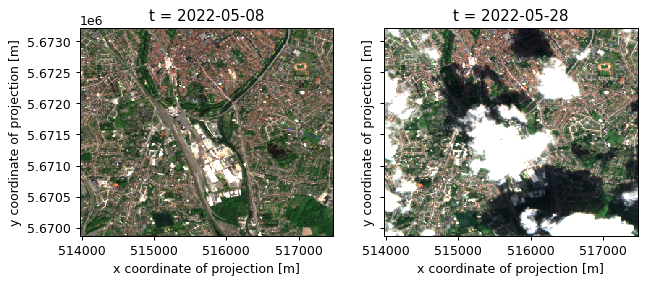

In [7]:
ds = xarray.load_dataset("load-raw.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);

Notice how the observation on the right suffers from clouds and cloud shadows.

## Data Processing


Let's include a bit of extra data processing.
We'll build a naive composite image by taking the temporal maximum:

In [8]:
composite = s2_cube.max_time()

Download this composite and visualize it:

In [9]:
composite.download("load-composite.nc")

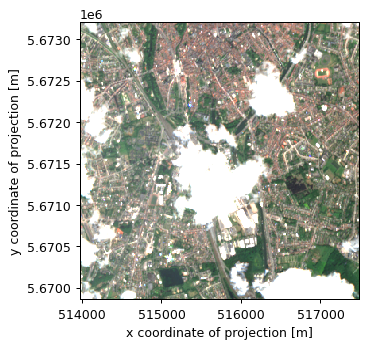

In [10]:
ds = xarray.load_dataset("load-composite.nc")
# Convert xarray DataSet to a (bands, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, ax = plt.subplots(ncols=1, figsize=(4, 4), dpi=90)
data.plot.imshow(vmin=0, vmax=2000, ax=ax)

Note how the clouds influence this composite: while the cloud shadows are eliminated by the `max` operation,
the bright clouds ruin the composite image.

## Cloud masking

In general, to make the raw data more useful, we typically want remove the cloud pixels and only work with non-cloud data.
It is very common for earth observation data to have separate masking layers that for instance indicate whether a pixel is covered by a (type of) cloud or not.
For Sentinel-2, one such layer is the "scene classification" layer (band name "SCL") generated by the Sen2Cor algorithm.

With openEO and the openEO Python client library, 
we can take this "SCL" band (which we already included before in the `load_collection` call)
and apply cloud masking as follows.

First we build a binary cloud mask from the SCL values 3 (cloud shadows), 8 (cloud medium probability) and 9 (cloud high probability):

In [11]:
scl_band = s2_cube.band("SCL")
cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)

# TODO: TEMP WORKAROUND FOR OFFSET ERROR ON SCL BAND
cloud_mask = (scl_band == 3 - 1000) | (scl_band == 8 - 1000) | (scl_band == 9 - 1000)

Before we can apply this mask to the cube we have to resample it, as the “SCL” layer has a “ground sample distance” of 20 meter, while it is 10 meter for the “B02”, “B03” and “B04” bands. 
We can easily do the resampling by referring directly to the data cube to mask.

In [12]:
cloud_mask = cloud_mask.resample_cube_spatial(s2_cube)

Apply the cloud mask, and build the composite again:

In [14]:
cube_masked = s2_cube.mask(cloud_mask)

composite_masked = cube_masked.max_time()

Download the result and visualize it.

In [15]:
composite_masked.download("load-composite-masked.nc")

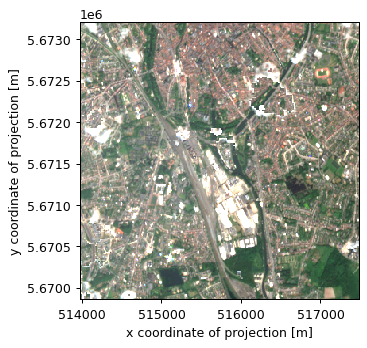

In [22]:
ds = xarray.load_dataset("load-composite-masked.nc")
# Convert xarray DataSet to a (bands, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, ax = plt.subplots(ncols=1, figsize=(4, 4), dpi=90)
data.plot.imshow(vmin=0, vmax=2000, ax=ax);

The cloud masking clearly helped to build a better composte.
Note however that there are still some artifacts due to the quality of the SCL band and our simple cloud mask.